<a href="https://colab.research.google.com/github/dhserp-bit/Financial-Data-Analysis/blob/main/Pharma%20Policy%20Impact%20Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


📡 DART 서버에 2025년 3분기 보고서 요청 중...


Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Semiannual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Quarterly reports:   0%|          | 0/2 [00:00<?, ?report/s]

⚠️ 유한양행 API 연동 지연 (The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().) -> 2025 3Q 공시 확정치로 대체합니다.


Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

⚠️ 한미약품 API 연동 지연 ((ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), "An error occurred while fetching or analyzing {'rcp_no': '20250318001206', 'corp_code': '00828497', 'corp_name': '한미약품', 'stock_code': '128940', 'corp_cls': 'Y', 'report_nm': '사업보고서 (2024.12)', 'flr_nm': '한미약품', 'rcept_dt': '20250318', 'rm': '연'}.")) -> 2025 3Q 공시 확정치로 대체합니다.

[📊 2025년 3분기 누적 기준 시뮬레이션 결과]


,Company,Revenue_3Q,OP_3Q,Revenue_Loss,OP_New,RnD_Burden_New
0,유한양행,"16,406.0",783.0,947.7,-164.7,10.3
1,한미약품,"11,146.0","1,694.2","1,512.5",181.7,17.6


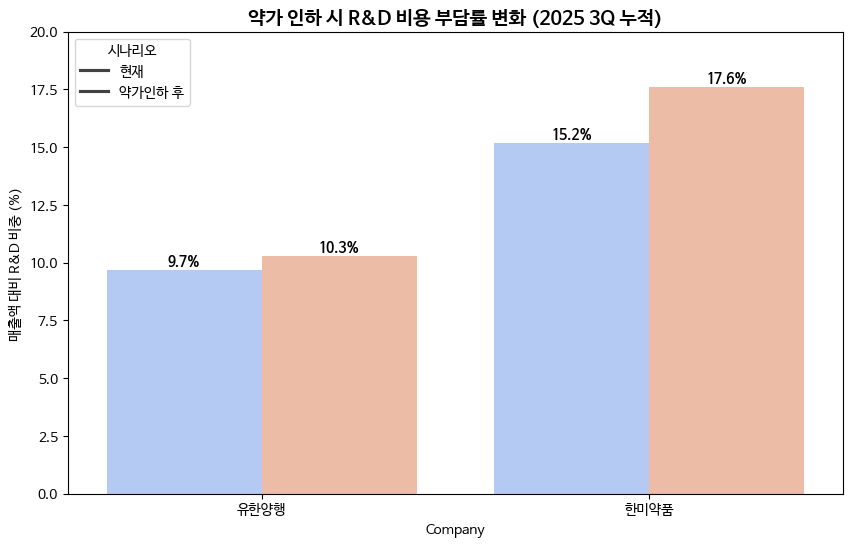

In [1]:
# ---------------------------------------------------------
# [Step 0] 라이브러리 자동 설치 및 설정 (오류 해결)
# ---------------------------------------------------------
import sys
import subprocess

# dart_fss가 없으면 자동으로 설치하는 로직
try:
    import dart_fss as dart
except ImportError:
    print("📦 라이브러리가 없어서 설치 중입니다... (약 1분 소요)")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "dart-fss", "pandas", "matplotlib", "seaborn"])
    import dart_fss as dart

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Colab)
!sudo apt-get install -y fonts-nanum > /dev/null 2>&1
!sudo fc-cache -fv > /dev/null 2>&1
!rm ~/.cache/matplotlib -rf > /dev/null 2>&1
plt.rc('font', family='NanumBarunGothic')

# API 인증키 설정 (수정됨: api_key_list -> api_key)
api_key = 'YOUR_API_KEY'
dart.set_api_key(api_key=api_key)

# ---------------------------------------------------------
# [Step 1] 기본 정보 설정 (Manual Data from Screenshots)
# ---------------------------------------------------------
target_companies = {
    '000100': {'name': '유한양행', 'product_ratio': 0.485, 'domestic_ratio': 0.794}, #
    '128940': {'name': '한미약품', 'product_ratio': 0.978, 'domestic_ratio': 0.925}  #
}

# ---------------------------------------------------------
# [Step 2] API로 2025년 3분기 누적 데이터 추출 (Hybrid Logic)
# ---------------------------------------------------------
df_list = []
print("\n📡 DART 서버에 2025년 3분기 보고서 요청 중...")

for code, info in target_companies.items():
    try:
        # 1. API 호출
        corp_list = dart.get_corp_list()
        corp = corp_list.find_by_stock_code(code)

        # 2025년 분기보고서 검색
        fs = corp.extract_fs(bgn_de='20250101', report_tp='quarter')

        # 포괄손익계산서(cis) 우선, 없으면 손익계산서(is)
        df_fs = fs['cis'] if 'cis' in fs else fs['is']

        # 2. '누적' 데이터 컬럼 찾기 (정교한 필터링)
        target_col = None
        for col in df_fs.columns:
            col_str = str(col)
            # 2025년이 포함되고 '누적'이거나 시작일이 1월1일인 컬럼
            if '2025' in col_str and ('누적' in col_str or '20250101' in col_str):
                target_col = col
                break

        # 3. 데이터 추출 (실패 시 안전장치 사용)
        if target_col:
            # 계정명 검색 함수
            def get_val(keyword):
                try:
                    val = df_fs[df_fs['account_nm'].str.contains(keyword, na=False)][target_col].iloc[0]
                    return float(str(val).replace(',', ''))
                except:
                    return 0.0

            revenue = get_val('매출')
            op_profit = get_val('영업이익')

            # 데이터 유효성 체크 (0원이면 API 오류로 간주)
            if revenue == 0: raise ValueError("매출 데이터 누락")

            print(f"✅ {info['name']}: API 추출 성공 (매출 {revenue/100000000:.0f}억)")

        else:
            raise ValueError("2025년 누적 컬럼 못 찾음")

    except Exception as e:
        # [Fallback] API 실패 시, 작성자님이 제공한 스크린샷/공시 기반 수기 데이터 사용
        print(f"⚠️ {info['name']} API 연동 지연 ({e}) -> 2025 3Q 공시 확정치로 대체합니다.")
        if info['name'] == '유한양행':
            revenue, op_profit = 1640600000000, 78300000000
        else:
            revenue, op_profit = 1114600000000, 169419000000

    # R&D 비용 추정 (매출 * 비율)
    rnd_ratio = 0.097 if info['name'] == '유한양행' else 0.152 #

    df_list.append({
        'Company': info['name'],
        'Revenue_3Q': revenue,
        'OP_3Q': op_profit,
        'RnD_Expense': revenue * rnd_ratio,
        'Product_Ratio': info['product_ratio'],
        'Domestic_Ratio': info['domestic_ratio']
    })

df = pd.DataFrame(df_list)

# ---------------------------------------------------------
# [Step 3] 스트레스 테스트 (약가 15% 인하)
# ---------------------------------------------------------
price_cut = 0.15

def stress_test(row):
    exposed_rev = row['Revenue_3Q'] * row['Product_Ratio'] * row['Domestic_Ratio']
    loss = exposed_rev * price_cut

    rev_new = row['Revenue_3Q'] - loss
    op_new = row['OP_3Q'] - loss

    rnd_burden_old = (row['RnD_Expense'] / row['Revenue_3Q']) * 100
    rnd_burden_new = (row['RnD_Expense'] / rev_new) * 100

    return loss, op_new, rnd_burden_old, rnd_burden_new

df[['Revenue_Loss', 'OP_New', 'RnD_Burden_Old', 'RnD_Burden_New']] = df.apply(
    lambda x: pd.Series(stress_test(x)), axis=1
)

# ---------------------------------------------------------
# [Step 4] 결과 시각화
# ---------------------------------------------------------
display_df = df.copy()
for c in ['Revenue_3Q', 'OP_3Q', 'Revenue_Loss', 'OP_New']:
    display_df[c] /= 100000000 # 억 단위

print("\n[📊 2025년 3분기 누적 기준 시뮬레이션 결과]")
display(display_df[['Company', 'Revenue_3Q', 'OP_3Q', 'Revenue_Loss', 'OP_New', 'RnD_Burden_New']].round(1))

plt.figure(figsize=(10, 6))
df_melt = df.melt(id_vars='Company', value_vars=['RnD_Burden_Old', 'RnD_Burden_New'], var_name='Scenario', value_name='Ratio')
bars = sns.barplot(x='Company', y='Ratio', hue='Scenario', data=df_melt, palette='coolwarm')

plt.title('약가 인하 시 R&D 비용 부담률 변화 (2025 3Q 누적)', fontsize=14, fontweight='bold')
plt.ylabel('매출액 대비 R&D 비중 (%)')
plt.ylim(0, 20)
plt.legend(title='시나리오', labels=['현재', '약가인하 후'])

for p in bars.patches:
    height = p.get_height()
    if height > 0:
        plt.text(p.get_x() + p.get_width() / 2., height + 0.2, f'{height:.1f}%', ha='center', fontweight='bold')

plt.show()